In [40]:
# optimise a pupil on the crowded field?? 

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'inferno'

from pathlib import Path

In [41]:
# jax random key
key = jr.PRNGKey(3)

wf_npix = 256 
diameter = 0.125 # toliman diameter

wavelength = 585e-9 # 1 micron wavelength

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 64 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# number of sources, random positions
# let's go with the middle 75% of the psf
image_fac = 0.5
max_dist = dlu.arcsec2rad(psf_pixel_scale*psf_npix/2*image_fac)

n_sources = 10
positions = jr.uniform(key, (n_sources,2), minval = -max_dist, maxval = max_dist)

# uniform distribution of fluxes in logspace
log_fluxes = jr.uniform(key, (n_sources,) ,minval=5, maxval=6)
fluxes = 10**(log_fluxes)

# I wish I could just use the following, but it breaks with the fisher matrix (position inference)
# sources = dl.PointSources(np.array([wavelength]), positions, fluxes)
sources = []
for i in range(n_sources):
    source = dl.PointSource(np.array([wavelength]), positions[i], fluxes[i])
    sources.append(source)

scene = dl.Scene(sources)

# import the particular pupil
climb_basis = np.load("../xk4/files/basis.npy")

coefficients = 0.1*(100)*jr.normal(key, [len(climb_basis)])
mean_wl = wavelength

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer,
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

model = dl.Telescope(optics, scene)

data = model.model()

In [42]:
src_keys = sorted(model.source.sources.keys(),
                  key=lambda k: int(k.split('_')[-1]))

# 2) Build parameter paths for all positions
marginal_params = [f"source.sources.{k}.position" for k in src_keys]


In [43]:
def crb_pos(wavelength, diameter, flux):
    crb = ( np.sqrt(2)/(np.pi*np.sqrt(flux)) ) * (wavelength/diameter)
    return crb


opt_params = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_params)

def fim_loss_func(model, parameters):
        
    data = model.model()

    cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)

    pos_errors = 0

    for i in range(n_sources):
        rms_error = np.sqrt(cov[i,i] + cov[i+1,i+1])

        crb = crb_pos(wavelength, diameter, fluxes[i])

        pos_errors += rms_error/crb

    # loss
    loss = pos_errors
    
    return loss

In [44]:
optim, opt_state = zdx.get_optimiser(model, opt_params, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(200), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

In [45]:
final_model = models_out[np.argmin(np.array(losses))]
final_data = final_model.model()
final_phase = final_model.get_binary_phase()
transmission = final_model.aperture.transmission

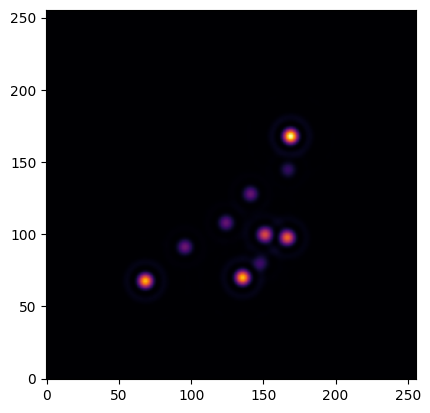

In [ ]:
plt.imshow(final_data)
# it just converged on an airy disk D:
# obviously need some regulariser.